### How to use this notebook
 - Enter the details requested in part 1
 - In part 2 each cell will execute a different analysis. Feel free to use and modify based on your own needs.
 
 ##### Assumptions made by this notebook
  - Experimental data are a timeseries of images of duckweed growing in 24 plat wells. Image files are stored in the same directory according to the format "exptname_plate_wellID_yyyymmdd.jpg.
  - Experiment metadata are stored in a .json file, with information on which samples and media are in which wells. 

In [2]:
import random
import pandas as pd
import DuckbotExptSetupUtils as exp
import os
import json
import datetime
import pathlib
import re
import numpy as np
import cv2
from PIL import Image, ExifTags
# from plantcv import plantcv as pcv
import matplotlib

In [3]:

def file_to_datetime(filename):
    no_file_ending = filename.split(".")
    split_name = no_file_ending[0].split("_")
    date = split_name[3].split("-")
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    return year, month, day

def calculate_dpi(y, m, d):
    split_start_date = startdate.split("-")
    y0 = int(split_start_date[0])
    m0 = int(split_start_date[1])
    d0 = int(split_start_date[2])
    start = datetime.datetime(y0, m0, d0)
    end = datetime.datetime(y, m, d)
    diff = (end-start).days
    return(diff)

def find_plate_well_id(str):
    well_id = re.search('well(.+?)_', str).group(1)
    plate_id = re.search('plate(.+?)_well', str).group(1)
    return(f'Plate_{plate_id}_Well_{well_id}')

def add_data_acrossdfs(input_value, shared_column_name, search_df, desired_column):
    df_subset = search_df[search_df[shared_column_name] == input_value][desired_column] #Find the desired column from the matching part of the search_df
    df_as_list = list(df_subset) #Convert to list to wipe clean the index carried over from search dataframe. 
    desired_value = df_as_list[0] #Specify that we want what should be a single value, rather than a whole list with one entry
    return desired_value

  



### Part 1 - Define filenames and paths

In [4]:
print(os.getcwd())

/Users/Orlando/Documents/Github_clones/duckbot/notebooks


In [7]:
#Where is the Json file with the experiment metadata and what is it called?
metadata_dir =  '/Users/Orlando/Documents/Github_clones/duckbot/test_data/TestExptDir/'
# "/home/delangeo/duckbot_git_clone/duckbot/test_data/TestExptDir/" 
metadata_filename = 'TestFile.json'
metadata_path = metadata_dir + metadata_filename

#Where are the image files that you want to analyze and what is the experiment ID (should be first part of each image filename)
img_data_dir =  "/Users/Orlando/Documents/Github_clones/duckbot/test_data/odl_dataanalaysistest1"
# "/home/delangeo/duckbot_git_clone/duckbot/test_data/odl_dataanalaysistest1"
expt_prefix = "TestData"

#Where do you want the figures produced by this script to end up?
output_figure_dir = '/Users/Orlando/Documents/Github_clones/duckbot/test_data/'
# "/home/delangeo/duckbot_git_clone/duckbot/test_data/"

#What was day 0 for this experiment in format (yyyy-mm-dd)
startdate = "2022-07-01"

### Part 2 - Building a dataframe with percentage duckweed coverage in each image

In [9]:

p = pathlib.Path(img_data_dir)   # current directory, insert your directory here
data_filenames = [x.stem for x in p.glob('*.jpg')]

data_df = pd.DataFrame({"filename": data_filenames})
data_df['plate_well_id'] = data_df.apply(lambda row: find_plate_well_id(row.filename), axis=1)
data_df['date'] = data_df.apply(lambda row: row.filename[-10:], axis=1)
print(data_df)


                             filename    plate_well_id        date
0   TestData_plate1_wellA1_2022-07-05  Plate_1_Well_A1  2022-07-05
1   TestData_plate1_wellA1_2022-07-03  Plate_1_Well_A1  2022-07-03
2   TestData_plate1_wellA1_2022-07-01  Plate_1_Well_A1  2022-07-01
3   TestData_plate1_wellA4_2022-07-03  Plate_1_Well_A4  2022-07-03
4   TestData_plate1_wellA2_2022-07-05  Plate_1_Well_A2  2022-07-05
5   TestData_plate1_wellA3_2022-07-01  Plate_1_Well_A3  2022-07-01
6   TestData_plate1_wellA3_2022-07-03  Plate_1_Well_A3  2022-07-03
7   TestData_plate1_wellA4_2022-07-01  Plate_1_Well_A4  2022-07-01
8   TestData_plate1_wellA4_2022-07-05  Plate_1_Well_A4  2022-07-05
9   TestData_plate1_wellA2_2022-07-03  Plate_1_Well_A2  2022-07-03
10  TestData_plate1_wellA3_2022-07-05  Plate_1_Well_A3  2022-07-05
11  TestData_plate1_wellA2_2022-07-01  Plate_1_Well_A2  2022-07-01


In [10]:
#Processing images
with open(metadata_path) as metadata:
    expt_data = json.load(metadata)

plate_set_up = expt_data["sample_info"]
md_df = pd.DataFrame(plate_set_up)

In [11]:
data_df['media'] = data_df.apply(lambda row: add_data_acrossdfs(row.plate_well_id, 'plate_well_id', md_df, 'media'), axis=1)
data_df['genotype'] = data_df.apply(lambda row: add_data_acrossdfs(row.plate_well_id, 'plate_well_id', md_df, 'genotype'), axis=1)
data_df['replicate'] = data_df.apply(lambda row: add_data_acrossdfs(row.plate_well_id, 'plate_well_id', md_df, 'condition_replicate'), axis=1)

print(data_df.head())                


                            filename    plate_well_id        date media  \
0  TestData_plate1_wellA1_2022-07-05  Plate_1_Well_A1  2022-07-05  Mock   
1  TestData_plate1_wellA1_2022-07-03  Plate_1_Well_A1  2022-07-03  Mock   
2  TestData_plate1_wellA1_2022-07-01  Plate_1_Well_A1  2022-07-01  Mock   
3  TestData_plate1_wellA4_2022-07-03  Plate_1_Well_A4  2022-07-03  Mock   
4  TestData_plate1_wellA2_2022-07-05  Plate_1_Well_A2  2022-07-05  Salt   

  genotype  replicate  
0   Sp7498          1  
1   Sp7498          1  
2   Sp7498          1  
3   Sp7498          2  
4   Sp7498          2  


In [35]:
#Remove non-green pixels from images
filtered_img_dir = img_data_dir + "/green_filtered"
if not os.path.exists(filtered_img_dir):
    os.mkdir(filtered_img_dir)

amount_green = []

for file in os.listdir(img_data_dir):
    if ".jpg" in file:
        y, m, d = file_to_datetime(file)
        days_post_initiation = calculate_dpi(y, m, d)
        im = cv2.imread(os.path.join(img_data_dir, file))
        dpi= days_post_initiation
        green_pixels = 0   
        for i in range(im.shape[0]): #im.shape[0] is the y-axis
            for j in range(im.shape[1]): #im.shape[1] is the x returns X and Y axes of the image
                if im[i, j][0] > 0.9*im[i, j][1]:  #If more blue than green in pixel than set to black.         
                    im[i, j] = [0, 0, 0]
                if np.array([x < 90 for x in im[i, j]]).all():
                    im[i, j] = [0, 0, 0]
                else:
                    green_pixels += 1
        amount_green.append({"filename": file, "dpi": dpi, "green_pixels": float(green_pixels)})
        im_onlygreen = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(im)
        img.save(filtered_img_dir + "/" + "GREEN" + file)

#Some notes to make sense of the above code
#im[i,j] refers to all pixels in the image, each having an x (j) and y(i) coordinate. 
#if np.array([x < 90 for x in im[i, j]]).all() is looking for any pixels with saturation values under 90 in any channel
#Each pixel has a blue [0], green [1] and red [2] value. 

In [34]:
# def add_data(input_value, shared_column_name, search_df, desired_column):
#     df_subset = search_df[input_value in search_df[shared_column_name]][desired_column] #Find the desired column from the matching part of the search_df
#     df_as_list = list(df_subset) #Convert to list to wipe clean the index carried over from search dataframe. 
#     desired_value = df_as_list[0] #Specify that we want what should be a single value, rather than a whole list with one entry
#     return desired_value

In [36]:
pixel_df = pd.DataFrame(amount_green)
# print(pixel_df)
pixel_df['filename_no_ext'] = pixel_df.apply(lambda row: row.filename[0:-4], axis=1)

data_df['dpi'] = data_df.apply(lambda row: add_data_acrossdfs(row.filename, 'filename_no_ext', pixel_df, 'dpi'), axis = 1)
data_df['green_pixels'] = data_df.apply(lambda row: add_data_acrossdfs(row.filename, 'filename_no_ext', pixel_df, 'green_pixels'), axis = 1)

print(data_df)



                             filename    plate_well_id        date media  \
0   TestData_plate1_wellA1_2022-07-05  Plate_1_Well_A1  2022-07-05  Mock   
1   TestData_plate1_wellA1_2022-07-03  Plate_1_Well_A1  2022-07-03  Mock   
2   TestData_plate1_wellA1_2022-07-01  Plate_1_Well_A1  2022-07-01  Mock   
3   TestData_plate1_wellA4_2022-07-03  Plate_1_Well_A4  2022-07-03  Mock   
4   TestData_plate1_wellA2_2022-07-05  Plate_1_Well_A2  2022-07-05  Salt   
5   TestData_plate1_wellA3_2022-07-01  Plate_1_Well_A3  2022-07-01  Salt   
6   TestData_plate1_wellA3_2022-07-03  Plate_1_Well_A3  2022-07-03  Salt   
7   TestData_plate1_wellA4_2022-07-01  Plate_1_Well_A4  2022-07-01  Mock   
8   TestData_plate1_wellA4_2022-07-05  Plate_1_Well_A4  2022-07-05  Mock   
9   TestData_plate1_wellA2_2022-07-03  Plate_1_Well_A2  2022-07-03  Salt   
10  TestData_plate1_wellA3_2022-07-05  Plate_1_Well_A3  2022-07-05  Salt   
11  TestData_plate1_wellA2_2022-07-01  Plate_1_Well_A2  2022-07-01  Salt   

   genotype

In [48]:
# Create dataframe with means and standard deviations

#Create new dictionaries
analysis_dict = {'genotype': [], 'media' : [], 'dpi' : [], 'green_pixels': []}


genotype_df = data_df.groupby(['genotype']) #Returns a list of tuples with [0] being the group key and [1] the dataframe
for g in genotype_df:
#     analysis_df['genotype'].extend([g[0]] * len(g[1].index))
    media_df = g[1].groupby(['media'])
    for m in media_df:
#         analysis_df['media'].extend([m[0]] * len(m[1].index))
        dpi_df = m[1].groupby(['dpi'])
        for d in dpi_df:
#             print(d)
            analysis_dict['genotype'].append(list(d[1]['genotype'])[0])
            analysis_dict['media'].append(list(d[1]['media'])[0])
            analysis_dict['dpi'].append(d[0])
            analysis_dict['green_pixels'].append(list(d[1]['green_pixels']))

# print(g)
analysis_df = pd.DataFrame(analysis_dict)

analysis_df['median_green_pixels'] = analysis_df.apply(lambda row: np.median(row.green_pixels), axis = 1)
analysis_df['stdev_green_pixels'] = analysis_df.apply(lambda row: np.std(row.green_pixels), axis = 1)
# analysis_df['median_green_pixels'] = analysis_df['green_pixels'].median()
# analysis_df['stdev_green_pixels'] = analysis_df['green_pixels'].stdev()

print(analysis_df)
# print(genotype_df[1])

#Iterate through rows to populate new dataframe. 


  genotype media  dpi        green_pixels  median_green_pixels  \
0   Sp7498  Mock    0  [13053.0, 15720.0]              14386.5   
1   Sp7498  Mock    2  [10210.0, 10054.0]              10132.0   
2   Sp7498  Mock    4   [12320.0, 4667.0]               8493.5   
3   Sp7498  Salt    0    [7713.0, 8273.0]               7993.0   
4   Sp7498  Salt    2    [8987.0, 3311.0]               6149.0   
5   Sp7498  Salt    4    [7552.0, 7006.0]               7279.0   

   stdev_green_pixels  
0              1333.5  
1                78.0  
2              3826.5  
3               280.0  
4              2838.0  
5               273.0  


### Part 3 - Produce figures

#### Data display option - Growth curves
Connects datapoints averaged across replicates to produce a line of growth against time. 

  genotype media  dpi        green_pixels  median_green_pixels  \
0   Sp7498  Mock    0  [13053.0, 15720.0]              14386.5   
1   Sp7498  Mock    2  [10210.0, 10054.0]              10132.0   
2   Sp7498  Mock    4   [12320.0, 4667.0]               8493.5   
3   Sp7498  Salt    0    [7713.0, 8273.0]               7993.0   
4   Sp7498  Salt    2    [8987.0, 3311.0]               6149.0   
5   Sp7498  Salt    4    [7552.0, 7006.0]               7279.0   

   stdev_green_pixels  
0              1333.5  
1                78.0  
2              3826.5  
3               280.0  
4              2838.0  
5               273.0  
  genotype media  dpi        green_pixels  median_green_pixels  \
0   Sp7498  Mock    0  [13053.0, 15720.0]              14386.5   
1   Sp7498  Mock    2  [10210.0, 10054.0]              10132.0   
2   Sp7498  Mock    4   [12320.0, 4667.0]               8493.5   

   stdev_green_pixels  
0              1333.5  
1                78.0  
2              3826.5  
  genoty

/Users/Orlando/virtualenvs/duckbot/duckbot_jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


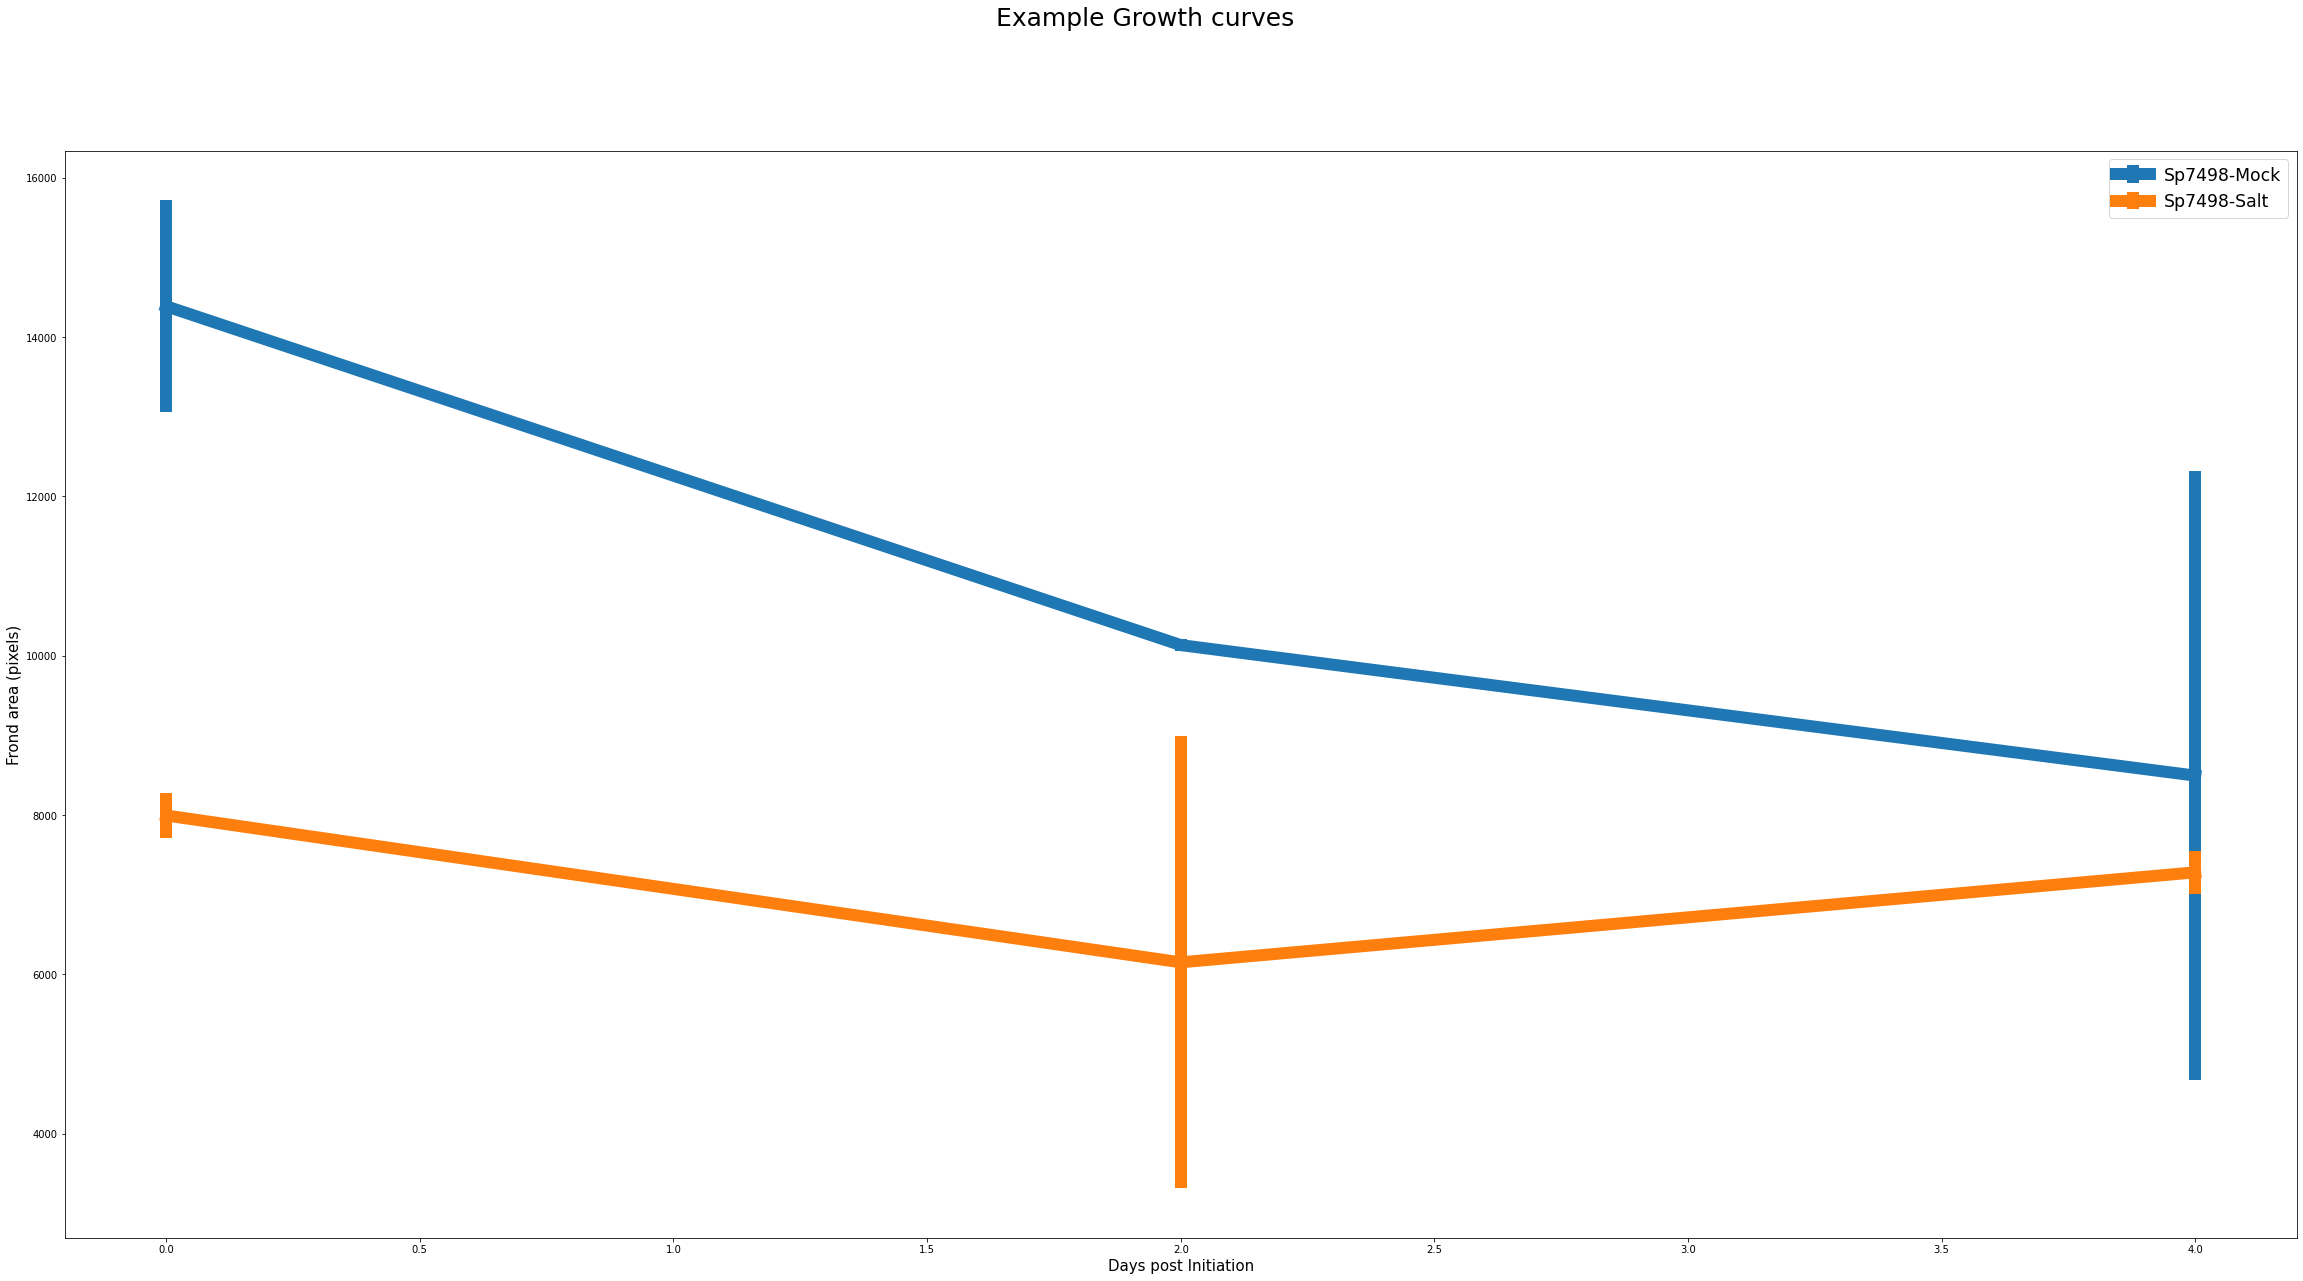

In [57]:
#8. Create and save figure

import matplotlib.pyplot as plt
genotype = np.unique(analysis_df["genotype"])
media = np.unique(analysis_df["media"])

fig, ax = plt.subplots(figsize=(40, 20))
for g in genotype:
    g_df = analysis_df[analysis_df["genotype"] == g]
    print(g_df)
    for m in media:
        m_df = g_df[g_df["media"] == m]
        print(m_df)
        ax.errorbar(m_df['dpi'], m_df["median_green_pixels"],yerr=m_df["stdev_green_pixels"], label=g+"-"+m, linewidth=12)

ax.legend(loc='upper right',fontsize='xx-large')
fig.suptitle("Example Growth curves", size = 25,wrap = False)
ax.set_xlabel("Days post Initiation", size = 15)
ax.set_ylabel("Frond area (pixels)", size = 15)

fig.show()
# ax.set_xscale('log')
# os.chdir(data_host_dir)
# fig.savefig(fig_filename)


In [2]:






from cycler import cycler
# import cycler
import matplotlib as mpl

colors = ["#345eeb", "#1bd12d", "#e38d0b", "#eb0cd4", "#000000"]
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', colors)
fig, ax = plt.subplots()
for conc in list(cond_dict.keys()):
    x = np.array(list(cond_dict[conc].keys()))
    y = np.array(list(cond_dict[conc].values()))
    plt.yscale('log')
    err = list(err_dict[cond])
    ax.errorbar(x, y, err, label = conc)
  
plt.legend(title="NaCl Conc. (mM)")
plt.ylabel("Log Average Area of Green Fronds ({}\u00b2)".format("mm"))
plt.xlabel("Days")
plt.savefig("Area_vs_Concentration_fig_4b.jpg")
plt.show()

### Data display option - Dose Response curve
Note that this analylsis only makes sense if your experiment involved a series of media conditions along a quantitative axis (i.e. concentration of a particular additive). 

In [ ]:
xdata = list(cond_dict.keys())
ydata = [cond_dict[cond][4]/cond_dict[cond][0] for cond in xdata]

def residual(params, x, y):
    def f(x):
        return (params['L']/(1.0 + math.e**(-1*params['k']*(x-params['x0']))))
    yval = f(x)
    errs = [abs((a-b)) for a, b in zip(y, yval)]
    return errs

#depending on the data, need to go thru and refine the starting conditions
p = Parameters()
p.add('L', value=max(ydata))
p.add('k', value=.01)
p.add('x0', value=xdata[-1]/2)


result = minimize(residual,p,args=(xdata,ydata))
result.params.pretty_print()


xvals = np.linspace(0,max(xdata),420)
plt.plot(xvals,(result.params['L'] /(1.0 + math.e**(-1*result.params['k']*(xvals-result.params['x0'])))), c = 'black')

plt.text(230, 1.95, "L = %.2f\nk = %.2f\nx0 = %.2f" % (result.params['L'], result.params['k'], result.params['x0']))
plt.xlabel("NaCl Concentration (mM)")
plt.ylabel("Normalized Growth Over 10 Days")
plt.scatter(xdata,ydata, c = 'black')
plt.savefig("dose_response_4c.jpg")


#### Part 2


In [ ]:
#